In [1]:

import sys

sys.path.insert(0,'..')
sys.path.insert(0,'../..')

import pandas as pd
import matplotlib.pyplot as plt
from meta_learning import evaluator
from sklearn.metrics import mean_squared_error

In [ ]:
def _get_mean_mse(cols: list, data_frame: pd.DataFrame, metric: str=None, window_size: int = 30):
    result_mse = pd.DataFrame(columns=cols)
    if not metric:
        metric = cols[0].split("_")[0]
    for result_idx, original_idx in enumerate(range(0, data_frame.shape[0] - window_size, window_size)):
        batch = data_frame.iloc[original_idx:original_idx + window_size]
        for col in cols:
            result_mse.loc[result_idx, col] = mean_squared_error(batch[metric], batch[col])
    return result_mse.mean(axis=1)

def _get_result_df(filename: str):
    df = pd.read_csv(filename).dropna()
    metrics = list(set(df.columns).intersection(set(evaluator.binary_clf_metrics)))
    results_df = pd.DataFrame()
    for metric in metrics:
        metric_cols = [col for col in df.columns if metric in col]
        with_drift_cols = [col for col in metric_cols if "with_drift" in col]
        without_drift_cols = [col for col in metric_cols if "without_drift" in col]
        results_df[f"{metric}_mse_with_drift"] = _get_mean_mse(with_drift_cols, data_frame=df)
        results_df[f"{metric}_mse_without_drift"] = _get_mean_mse(without_drift_cols, data_frame=df)
        results_df[f"{metric}_mse_baseline"] = _get_mean_mse([f"last_{metric}"], metric=metric, data_frame=df)
    return results_df, metrics

def _plot_subplot(results_df: pd.DataFrame, title: str, include_optimal: bool, metric="kappa"):
    plt.title(title)

    mtl_with_drift_error = results_df[f"{metric}_mse_with_drift"]
    mtl_without_drift_error = results_df[f"{metric}_mse_without_drift"]
    mtl_with_drift_gain = mtl_without_drift_error - mtl_with_drift_error

    df_plot = pd.DataFrame()
    df_plot["meta_learning_with_drift"] = mtl_with_drift_gain.cumsum()
    if include_optimal:
        df_plot["optimal_regressor"] = mtl_without_drift_error.cumsum()
    df_plot.plot.area(stacked=False, ax=plt.gca())#, color=COLORS)

# Datasets

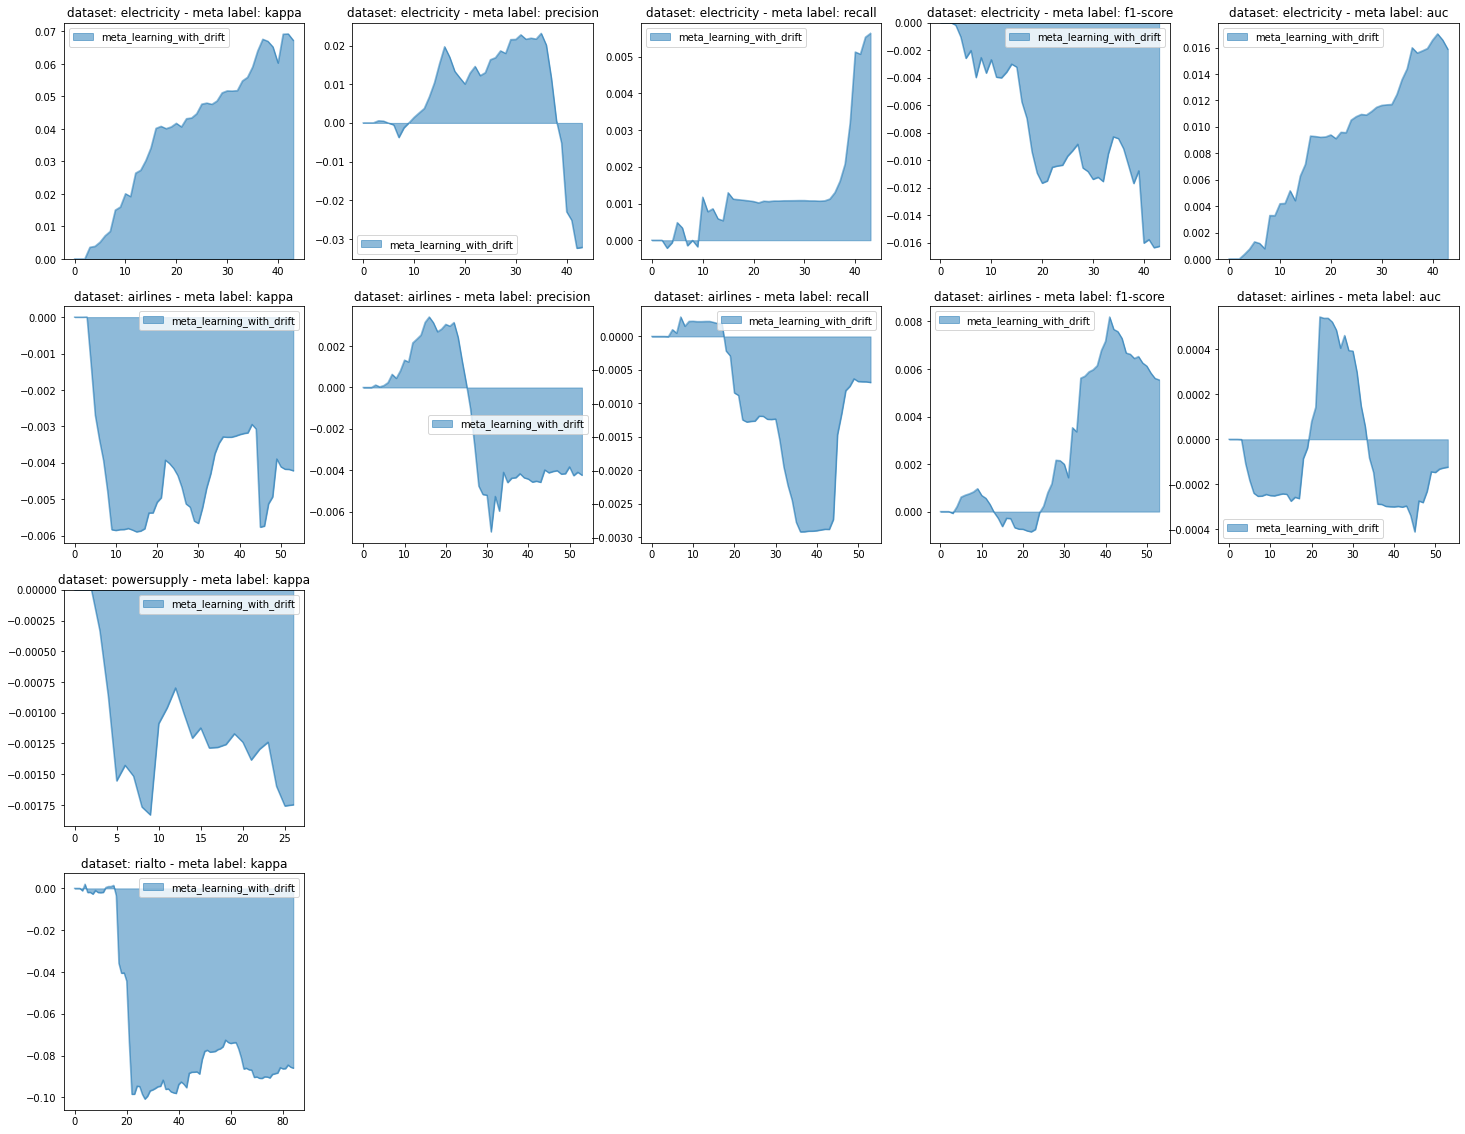

In [17]:
def _plot_results(include_optimal: bool=False):
    plt.figure(figsize=(25, 20))
    base_model = "RandomForestClassifier"
    datasets = ["electricity", "airlines", "powersupply", "rialto"]
    results = {}
    for dataset_idx, dataset in enumerate(datasets):
        filename = f"results_dataframes/base_model: {base_model} - dataset: {dataset}.csv"
        results[dataset], metrics = _get_result_df(filename)
        for metric_idx, metric in enumerate(metrics):
            subplot_idx = dataset_idx * 5 + metric_idx
            plt.subplot(4, 5, subplot_idx+1)
            _plot_subplot(results[dataset], f"dataset: {dataset} - meta label: {metric}", include_optimal=include_optimal, metric=metric)

_plot_results()
        

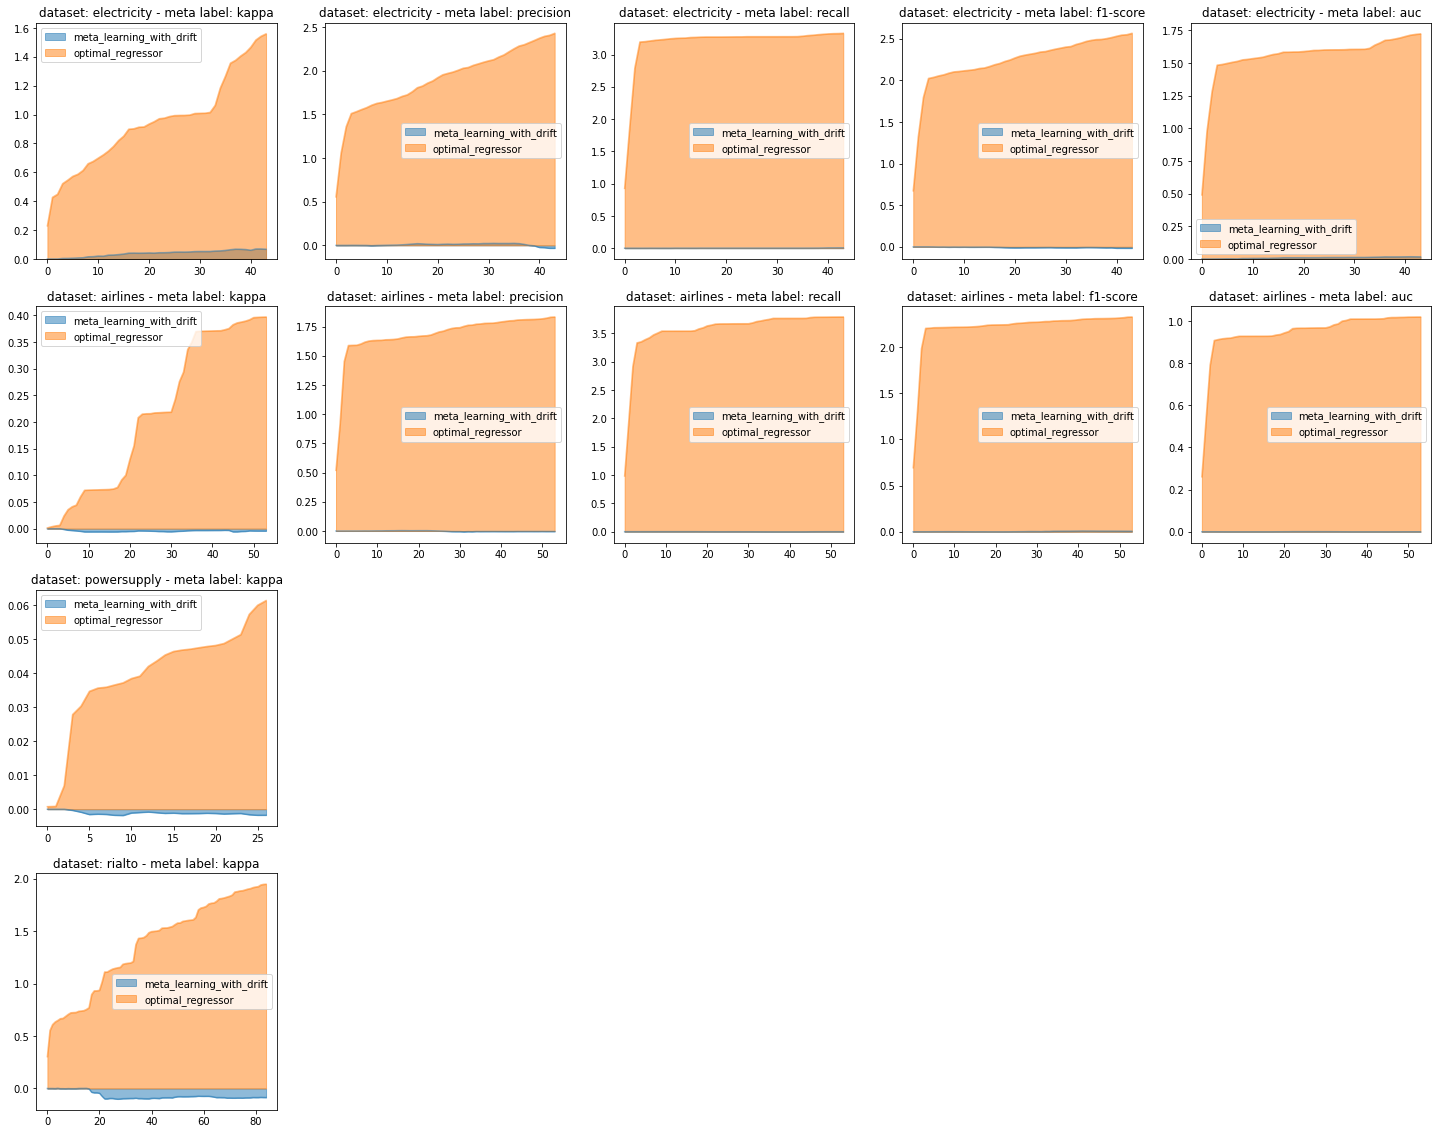

In [18]:
_plot_results(True)

# Base models

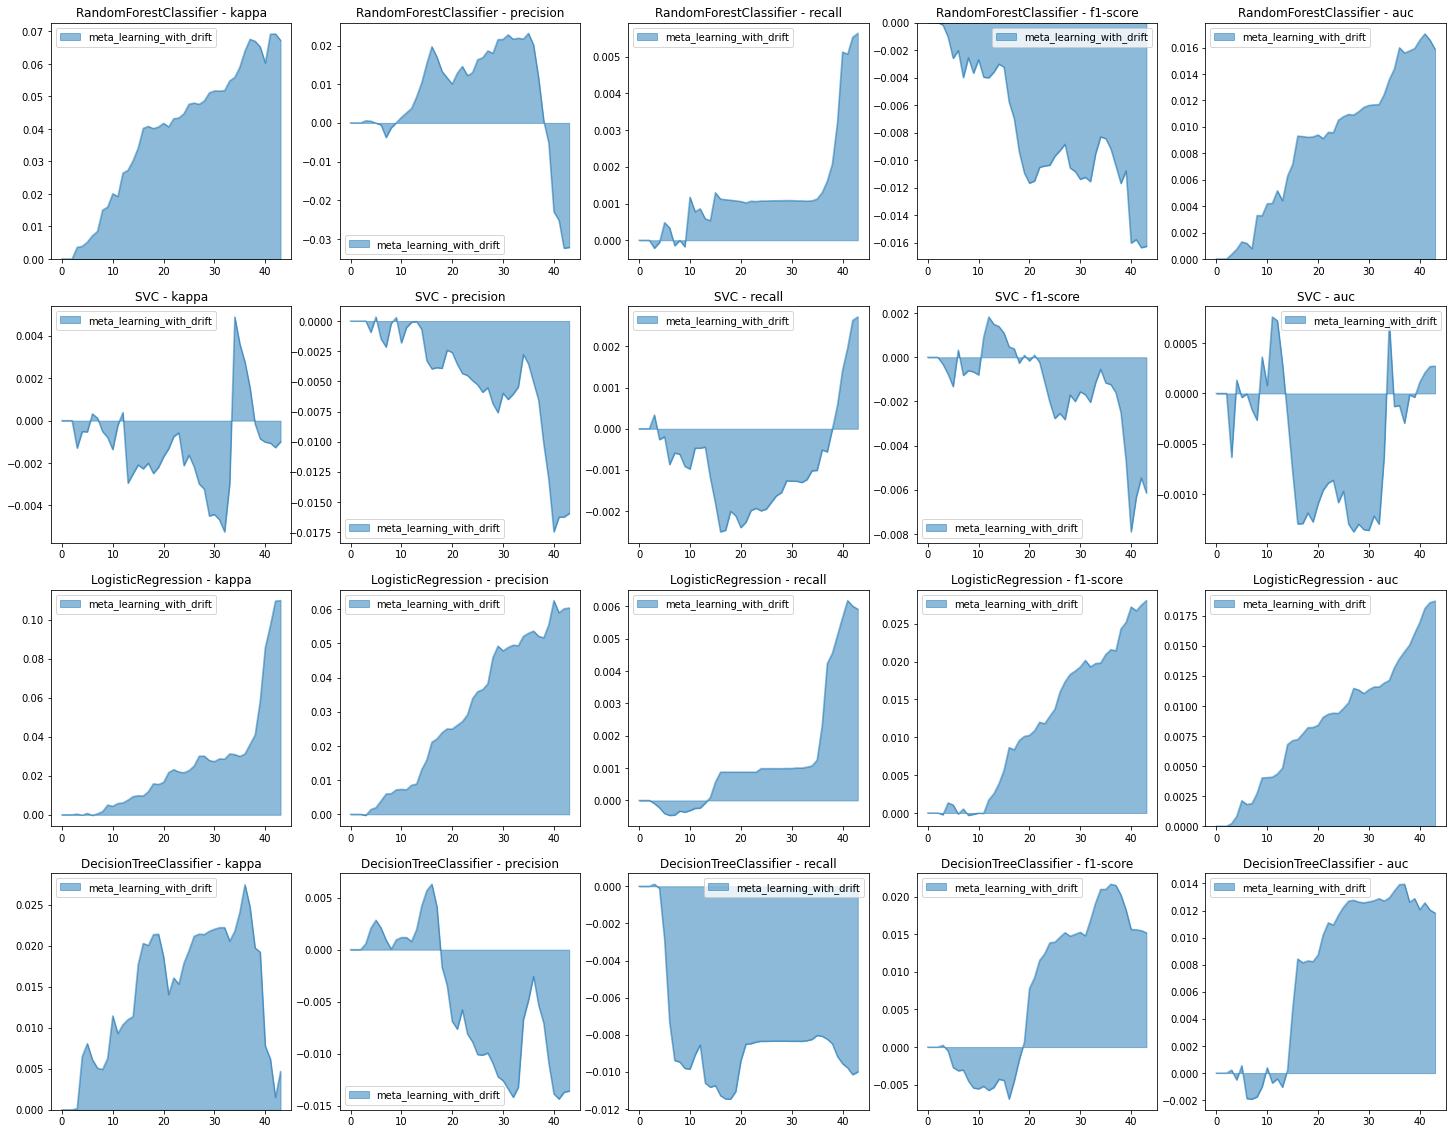

In [20]:
def _plot_results(include_optimal: bool=False):
    plt.figure(figsize=(25, 20))
    base_models = ["RandomForestClassifier", "SVC", "LogisticRegression", "DecisionTreeClassifier"]
    dataset = "electricity"
    results = {}
    for base_model_idx, base_model in enumerate(base_models):
        filename = f"results_dataframes/base_model: {base_model} - dataset: {dataset}.csv"
        results[dataset], metrics = _get_result_df(filename)
        for metric_idx, metric in enumerate(metrics):
            subplot_idx = base_model_idx * 5 + metric_idx
            plt.subplot(4, 5, subplot_idx+1)
            _plot_subplot(results[dataset], f"{base_model} - {metric}", include_optimal=include_optimal, metric=metric)

_plot_results()

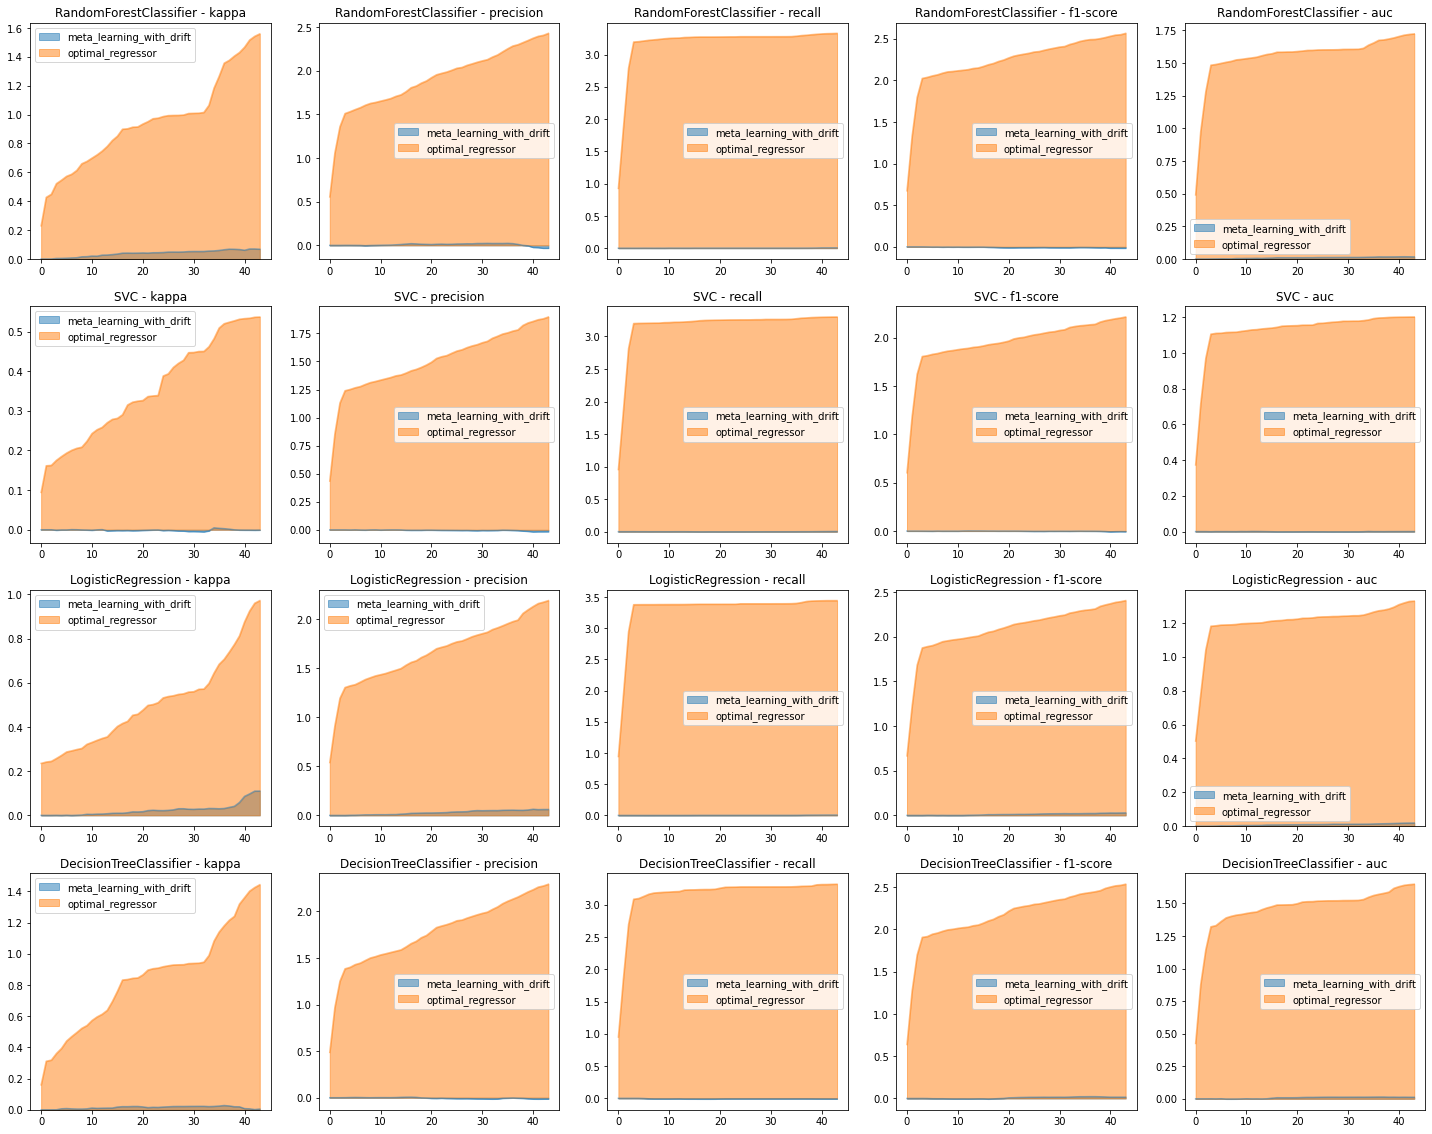

In [21]:
_plot_results(True)